## Решение

1. Профилировшик времени исполнения кода, явно указывает на "узкое место" в обращении к разреженной матрице:
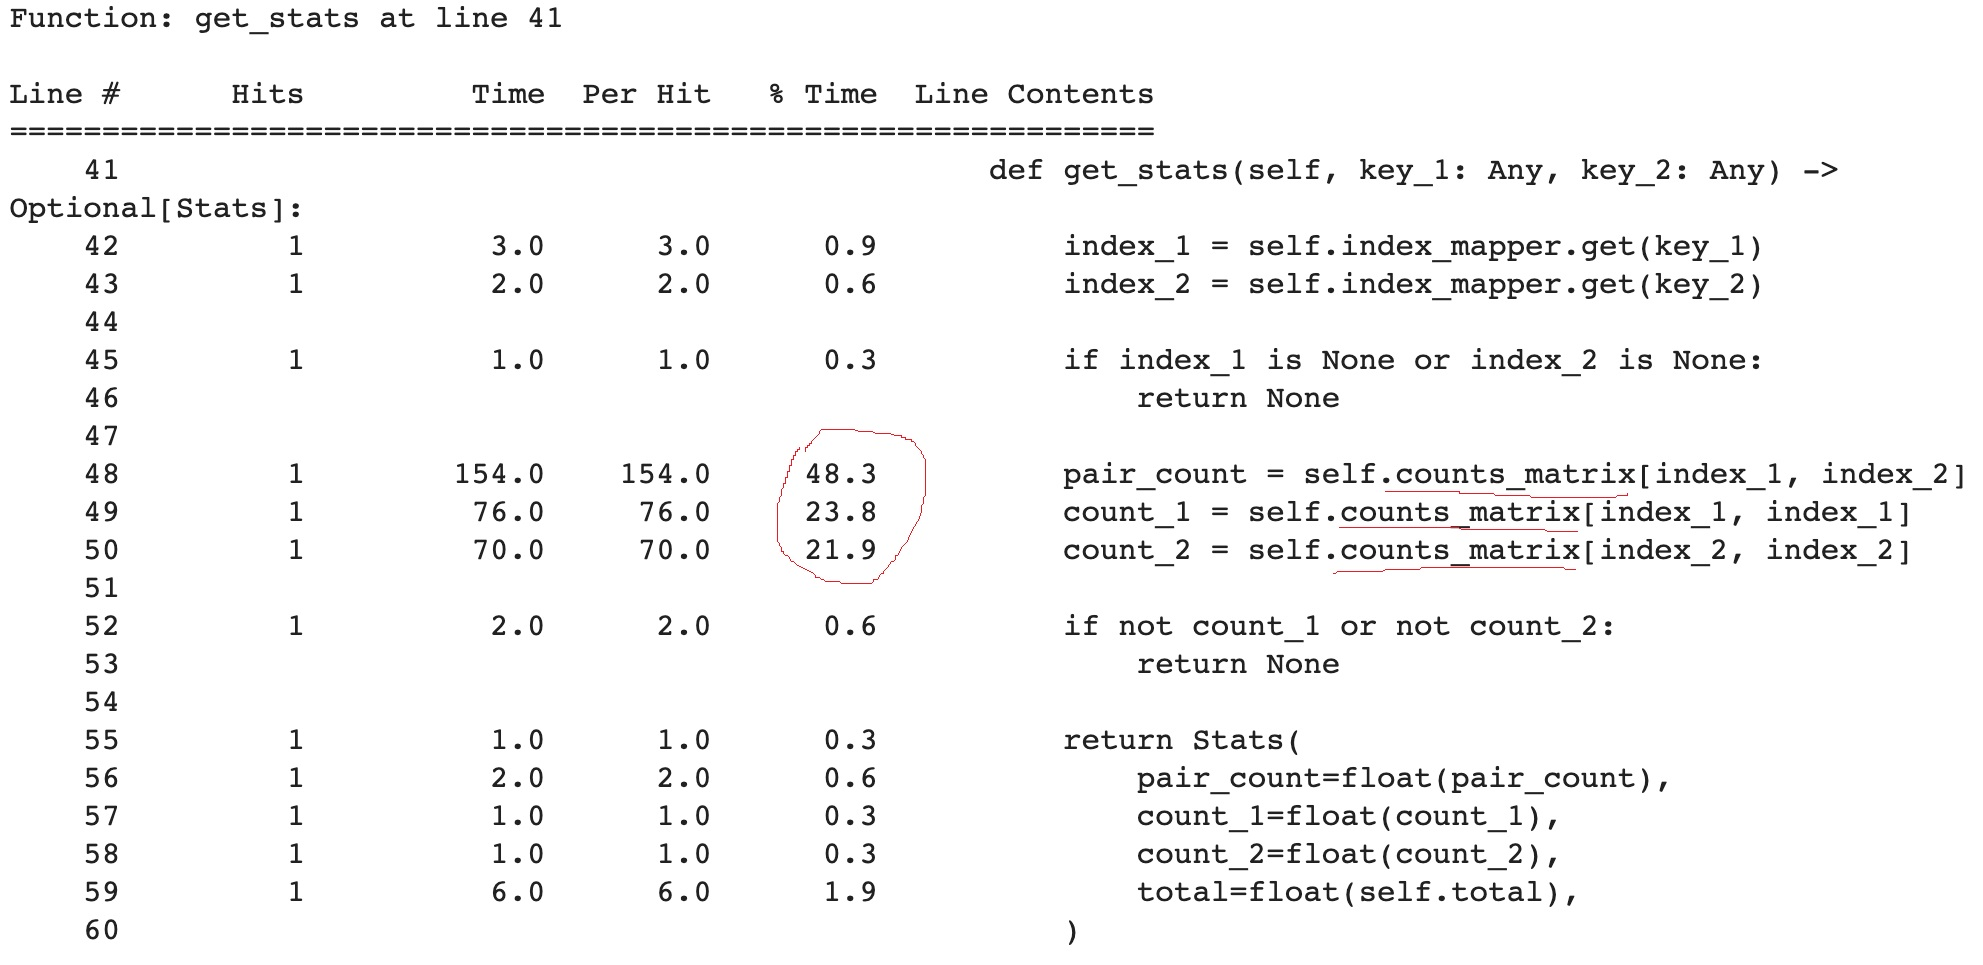

2. Тк разреженная матрица генерируется статическим методом .from_dict(), да и в целом ее использование я считаю логичным, вопрос смены структуры данных не ставим. Следовательно необходимо оптимизировать(сократить) обращения к ней.
3. Явное решение основывается на том, что данная матрица симметрична и соответсвенно pmi(x, y) = pmi(y, x), следовательно кол-во обращений можно сохранить как миниум вдвое, кешируя вычисления.
4. Есть два пути для кеширования - использовать joblib.memory, либо кешировать самостоятельно в коде. Я выбираю второй путь тк он не будет терять время на IO обращений к диску и к тому же "по пути" есть еще несколько minor оптимизаций кода.



**5. Мои оптимизации:**

5.1.   При последовательном(важно!) обращении к симметричной матрице я проверяю 
не явлется ли вторая координата меньше первой, если является значит обращение к близнецу этой ячеки уже было и значит этого повторного обращения можно избежать, взяв его результат из первого сохраненного обращения.  

5.2.   Для кеширования я создаю свойство класса **self.pmi_cache: Dict[Tuple, float]**, куда сохраняю уже вычисленный **pmi** для пары **[index_1, index_2]** при первом обращении по данным координатам. Когда данная пара будет запрошена второй раз (координаты поменяются местами) я беру уже вычисленное ранее значение из этого словаря медотом pop - это важно, чтобы данный словарь не разростался по памяти, тк более зеркальных значений в двумерной матрице нет и третьего запроса уже не будет. Таким образом сокращается кол-во обращений к разреженной матрице в два раза и так же сокращаются высиления тк кешируются уже вычисленные **pmi**.  

  5.3. Minor оптимизация. Тк мы проходимся по матрице последовательно то первая координата является константой в течении n запросов, потом инкрементируется и снова константна n итераций. Для экономии на этом вычислении я сохраняю для первого индекса значение **p()** в свойстве **self.current_count**, где сразу храню его во **float**, для контроля использую флаг **self.current_ind**. Таким образом дополнительно экономится обращение к разреженной матрице **counts_matrix[index_1, index_1]** в n раз меньше!  

  5.4. Каждое вычисление pmi мы приводим константное значение свойства **self.total** к типу **float**. Не могу я пройти мимо и не привести его один раз и хранить уже в классе как **float**) 



# Результат:
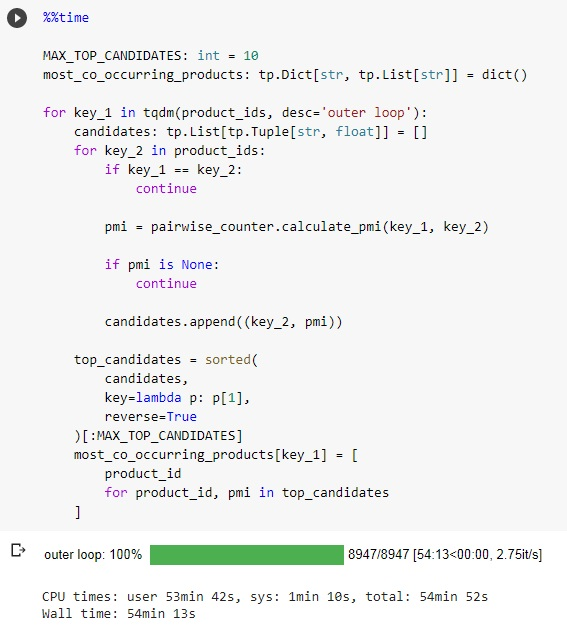

# Комментари:
1. Такая оптимизация будет работать только при последовательном обращении к матрице. Такое обращение и реализовано в задании. При произвольном же обращении следует заменить код в методе calculate_pmi():
        if index_2 < index_1:
            res = self.pmi_cache.pop((index_2, index_1))
        else:
            res = self._calculate_pmi_cache(index_1, index_2)
на:
        res = self.pmi_cache.pop((index_2, index_1), None)
        if not res:
            res = self._calculate_pmi_cache(index_1, index_2)
он чуть более затратен по ресурсам тк обращение к словарю происходит каждый запрос.  


2. Я кеширую значения pmi по аргументам индексам (**index: int**). Их же вычисление из словаря **index = self.index_mapper.get(key)** остаются в прежнем колличестве без изменений. Можно было кешировать по аргументам **key: Any** и тогда была бы экономия еще и на данных запросах к словарю.
  

3. Почему я не использую встроенные возможности оптимизации:  

    **Jit компиляцию** не использую тк: Мы используем здесь scipy. Методы нашего класса выкидывают исключение на nopython=True, а без этого и эффекта почти не будет. При использовании @jitclass для класса целиком аналогично.  

    Прочая **multithreading оптимизация** - имеет смысл только наличии операций IO, в нашем классе обращений к вводу-выводу нет, за исключением быть может если бы мы использовали joblib.memory

    **multiprocessing с joblib** будет иметь огромный overhead в виду большого размера нашего обьекта класса. Если его и делать в ячейке с циклами, то лучше вручную чтобы контролировать последовательность обращений к матрице и соответственно сохранить эффект от примененной выше оптимизации.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%writefile pairwise_counter.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple

import numpy as np

from scipy import sparse


# need for log(0) where pair_count = 0
# do not affect results
EPS = 1e-100


class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float


class PairwiseCounter:

    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = float(self.counts_matrix[total_index, total_index])
        self.pmi_cache: Dict[Tuple, float] = {}
        self.current_ind: int = 0
        self.current_count: float = float(self.counts_matrix[0, 0])

    # This method could be deleted
    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)

        if index_1 is None or index_2 is None:
            return None

        pair_count = self.counts_matrix[index_1, index_2]
        count_1 = self.counts_matrix[index_1, index_1]
        count_2 = self.counts_matrix[index_2, index_2]

        if not count_1 or not count_2:
            return None

        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1),
            count_2=float(count_2),
            total=float(self.total),
        )

    def _calculate_pmi_cache(self, index_1: int, index_2: int) -> float:
        pair_count = self.counts_matrix[index_1, index_2]
        count_2 = self.counts_matrix[index_2, index_2]
        if not count_2:
            return None
        if index_1 != self.current_ind:
            count_1 = self.counts_matrix[index_1, index_1]
            if count_1:
                self.current_ind = index_1
                self.current_count = float(count_1)
            else:
                return None

        pmi = np.log(float(pair_count) + EPS) \
            + np.log(self.total) \
            - np.log(self.current_count) \
            - np.log(float(count_2))
        
        self.pmi_cache[(index_1, index_2)] = pmi
        return pmi

    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """

        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)

        if index_1 is None or index_2 is None:
            return None
 
        if index_2 < index_1:
            res = self.pmi_cache.pop((index_2, index_1))
        else:
            res = self._calculate_pmi_cache(index_1, index_2)

        return res
    
    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )

    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )

Overwriting pairwise_counter.py


## Импорт библиотек

In [3]:
import collections
import json
import typing as tp

from tqdm.auto import tqdm

from pairwise_counter import PairwiseCounter

In [4]:
!pip install line_profiler
%load_ext line_profiler

## Загрузка данных

Предполагается, что данные лежат в папке `/content`. Если вы примонтировали папку со своего Google Drive, измените пути соответствующим образом.

In [5]:
with open('drive/MyDrive/Colab Notebooks/product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
    pairwise_counter = PairwiseCounter.from_dict(json.load(infile))

In [6]:
product_ids = [
    product_id 
    for product_id in pairwise_counter.index_mapper.keys() 
    if product_id != pairwise_counter.total_key
]

test_product_ids = product_ids[0:20]

## Предподсчёт кандидатов для ранжирования

Класс `PairwiseCounter` нужен для того, чтобы предпосчитать кандидатов для ранжирования в рекомендательной системе. А именно: для каждого товара он находит `N` наиболее часто встречающихся вместе с ним в одной корзине (здесь `N = 10`). 

Тривиальная реализация этого функционала подразумевает два вложенных цикла. Это, очевидно, небыстро: сейчас  подсчёт занимает примерно 2 часа. **Ваша задача:** добиться максимального прироста производительности, изменяя только реализацию методов класса `PairwiseCounter` и функцию, которая вычисляет списки кандидатов (её можно менять как угодно, лишь бы ответы совпадали).

Методы `PairwiseCounter` нельзя менять по той причине, что он используется не только здесь, но и при вычислении признакового описания продуктовых корзин. Поэтому придётся работать с тем, что есть. 

В практике Яндекс.Лавки ускорение одного лишь класса `PairwiseCounter` значимо понизило долю таймаутов рекомендательной системы на треть, что дало дополнительные сотни тысяч рублей прибыли ежемесячно.

In [7]:
MAX_TOP_CANDIDATES: int = 10

def solve(
        product_ids: tp.List[tp.Any] = product_ids,
        max_top_candidates: int = MAX_TOP_CANDIDATES
    ):
    most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

    for key_1 in tqdm(product_ids, desc='outer loop'):
        candidates: tp.List[tp.Tuple[str, float]] = []
    for key_2 in product_ids: 
        if key_1 == key_2:
            continue

        pmi = pairwise_counter.calculate_pmi(key_1, key_2)
        if pmi is None:
            continue

        candidates.append((key_2, pmi))

        top_candidates = sorted(
            candidates, 
            key=lambda p: p[1], 
            reverse=True
        )[:max_top_candidates]
        most_co_occurring_products[key_1] = [
            product_id
            for product_id, pmi in top_candidates
        ]

#%lprun -f pairwise_counter.calculate_pmi solve()

In [ ]:
%%time

MAX_TOP_CANDIDATES: int = 10
most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

for key_1 in tqdm(product_ids, desc='outer loop'):
    candidates: tp.List[tp.Tuple[str, float]] = []
    for key_2 in product_ids: 
        if key_1 == key_2:
            continue

        pmi = pairwise_counter.calculate_pmi(key_1, key_2)

        if pmi is None:
            continue

        candidates.append((key_2, pmi))

    top_candidates = sorted(
        candidates, 
        key=lambda p: p[1], 
        reverse=True
    )[:MAX_TOP_CANDIDATES]
    most_co_occurring_products[key_1] = [
        product_id
        for product_id, pmi in top_candidates
    ]

In [9]:
with open('most_co_occurring_products.txt', 'w') as outfile:
    json.dump(most_co_occurring_products, outfile)

**ВАЖНО:** Прикрепите скриншоты со сравнением времени работы исходного решения и вашего. Суть ваших правок должна быть понятна преподавателям без необходимости запускать ваш код!